<a href="https://colab.research.google.com/github/benisde/recommended_movie/blob/project2_branch1/movie_recommendation_system_final_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from string import punctuation
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import io
from google.colab import files

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Upload the CSV file
uploaded = files.upload()

# Read the CSV file using io module
data = pd.read_csv(io.StringIO(uploaded['movies_metadata.csv'].decode('utf-8')))

Saving movies_metadata.csv to movies_metadata.csv


Pre-process and clean the data

In [5]:
# Drop unnecessary columns
data = data.drop(columns=['id', 'original_title', 'production_companies', 'production_countries', 'status', 'tagline'])

# Remove rows with missing data
data = data.dropna()

# Convert release_date to datetime
data['release_date'] = pd.to_datetime(data['release_date'])

Create a function to extract keywords from the overview

In [7]:
def get_keywords(text):
    # Remove punctuation
    text = ''.join([c for c in text if c not in punctuation])

    # Tokenize and remove stop words
    tokens = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    # Return a list of keywords
    return tokens

Create a TF-IDF matrix for the overview text

In [8]:
# Create the TF-IDF vectorizer
tfidf = TfidfVectorizer(tokenizer=get_keywords)
# Compute the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(data['overview'])

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Calculate cosine similarity between movies

In [9]:
#This code calculates the cosine similarity between all pairs of documents in a corpus using the linear_kernel function from the sklearn.metrics.pairwise module.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Create a function to get movie recommendations based on keywords

In [10]:
# Define a function to get movie recommendations based on cosine similarity scores
def get_recommendations(title, cosine_sim=cosine_sim):
    
    # Get the index of the input movie title
    idx = indices[title]
    
    # Calculate cosine similarity scores for all movies compared to the input movie
    sim_scores = list(enumerate(cosine_sim[idx].flatten()))
    
    # Sort the cosine similarity scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top 10 most similar movies, excluding the input movie itself
    sim_scores = sim_scores[1:11]
    
    # Get the indices of the top 10 most similar movies
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the titles of the top 10 most similar movies
    return data['title'].iloc[movie_indices]

In [11]:
# Reset the index of the 'data' DataFrame
data.reset_index(drop=True, inplace=True)

# Update the 'indices' Series
indices = pd.Series(data.index, index=data['title']).drop_duplicates()

# Test the get_recommendations function
# Ask the user to input a movie title
user_movie_title = input("Enter a movie title: ")

try:
    # Test the get_recommendations function
    recommended_movies = get_recommendations(user_movie_title)
    print(f"Recommended movies for '{user_movie_title}':")
    print(recommended_movies)
except KeyError:
    print(f"The movie title '{user_movie_title}' was not found in the dataset. Please try again.")

Enter a movie title: Jumanji
Recommended movies for 'Jumanji':
16620    Table No. 21
5398        Brainscan
7536          Quintet
7979        Word Wars
23211    Turkey Shoot
29525    Snowed Under
8977       Stay Alive
11110      Rhinoceros
13238          DeVour
22826          Pixels
Name: title, dtype: object


Create a function to get movie recommendations based on genre

In [12]:
def get_genre_recommendations(genre, num_recommendations=10):
    # Filter movies by the specified genre
    filtered_movies = data[data['genres'].str.contains(genre, case=False, na=False)]
    
    # Sort movies by their vote_average in descending order
    sorted_movies = filtered_movies.sort_values('vote_average', ascending=False)
    
    # Return the top num_recommendations movies
    return sorted_movies[['title', 'vote_average']].head(num_recommendations)

In [13]:
# Test the get_genre_recommendations function
genre = input("Enter a genre: ")
num_recommendations = 10

try:
    recommended_movies = get_genre_recommendations(genre, num_recommendations)
    print(f"Top {num_recommendations} movies in the '{genre}' genre:")
    print(recommended_movies)
except ValueError:
    print(f"The genre '{genre}' was not found in the dataset. Please try again.")

Enter a genre: Comedy
Top 10 movies in the 'Comedy' genre:
                                              title  vote_average
19618               George Lopez: America's Mexican          10.0
18007                                    Tall Story          10.0
30188  Sebastian Maniscalco: Why Would You Do That?          10.0
20845                                The Little Hut          10.0
16500                             A Ticklish Affair          10.0
27164                              Bowery Battalion          10.0
16440                                 Growing Pains          10.0
21086                               Vessel of Wrath          10.0
21184                                 Heavy Weather          10.0
9101                                  Blessed Event          10.0


Create a function to get movie recommendations based on mood

In [14]:
mood_to_genre = {
    'happy': 'Comedy',
    'sad': 'Drama',
    'excited': 'Action',
    'romantic': 'Romance',
    'scared': 'Horror'
}

def get_mood_recommendations(mood, num_recommendations=10):
    genre = mood_to_genre.get(mood.lower())
    
    if genre:
        return get_genre_recommendations(genre, num_recommendations)
    else:
        raise ValueError(f"The mood '{mood}' was not found in the mood list. Please try again.")

In [15]:
# Test the get_mood_recommendations function
mood = input("Enter your mood {happy, sad, excited, romantic, scared}: ")
num_recommendations = 10

try:
    recommended_movies = get_mood_recommendations(mood, num_recommendations)
    print(f"Top {num_recommendations} movies for the mood '{mood}':")
    print(recommended_movies)
except ValueError as e:
    print(e)

Enter your mood {happy, sad, excited, romantic, scared}: sad
Top 10 movies for the mood 'sad':
                             title  vote_average
16604                 Almost Kings          10.0
19165  Let No Man Write My Epitaph          10.0
26082               Birch Interval          10.0
167                       Reckless          10.0
26723                       Mammal          10.0
17278                    Eggshells          10.0
29121             Titus Andronicus          10.0
21797     Southern Baptist Sissies          10.0
9101                 Blessed Event          10.0
17681                    Dragonfly          10.0


Create a function to recommend cult-classic movies based on genre

In [16]:
#Define a function to get recommendations for cult-classic movies based on genre, vote count, and vote average thresholds
def get_cult_classic_recommendations(genre, vote_count_threshold=100, vote_average_threshold=7.5, num_recommendations=10):
    # Filter the data based on the given genre, vote count, and vote average thresholds
    filtered_data = data[(data['genres'].str.contains(genre, case=False)) &
                     (data['vote_count'] < vote_count_threshold) &
                     (data['vote_average'] >= vote_average_threshold)]

    # Sort the filtered data by vote average in descending order
    filtered_data = filtered_data.sort_values(by='vote_average', ascending=False)

    # Return the top 'num_recommendations' movie titles
    return filtered_data['title'].head(num_recommendations)

In [17]:
# Test the get_cult_classic_recommendations function
genre = input("Enter the genre: ")
num_recommendations = 10

try:
    recommended_movies = get_cult_classic_recommendations(genre, num_recommendations=num_recommendations)
    print(f"Top {num_recommendations} cult-classic movies in the '{genre}' genre:")
    print(recommended_movies)
except Exception as e:
    print(e)

Enter the genre: Horror
Top 10 cult-classic movies in the 'Horror' genre:
30310                           Zombie Pizza
29217                Killjoy's Psycho Circus
17732                       Ghost Adventures
18032                               Jennifer
9709             The Legend of Sleepy Hollow
18257                          The Strangler
1135                       Vampire in Venice
18667    National Theatre Live: Frankenstein
2251                        The Mummy's Tomb
18564                                Ward 13
Name: title, dtype: object


Analyze factors that correlate with the highest ROI (Revenue/Budget)

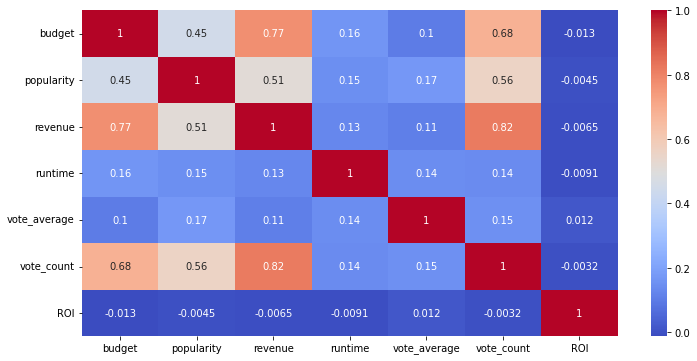

In [18]:
# Calculate the ROI
data['ROI'] = data['revenue'] / data['budget']

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

Machine learning

In [19]:
# Select the features and target
X = data[['budget', 'popularity']]
y = data['revenue']

In [20]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Create the base estimator (DecisionTreeRegressor)
base_estimator = DecisionTreeRegressor(max_depth=4)

# Create the AdaBoostRegressor model
ada_model = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=100, random_state=42)

# Create the GradientBoostingRegressor model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [22]:
# Fit the models to the training data
ada_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GradientBoostingRegressor(random_state=42)

In [23]:
# Evaluate the models on the test set
ada_y_pred = ada_model.predict(X_test)
gb_y_pred = gb_model.predict(X_test)

In [24]:
# Calculate the evaluation metrics
ada_mse = mean_squared_error(y_test, ada_y_pred)
ada_rmse = np.sqrt(ada_mse)
ada_r2 = r2_score(y_test, ada_y_pred)

gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_rmse = np.sqrt(gb_mse)
gb_r2 = r2_score(y_test, gb_y_pred)

In [25]:
print("AdaBoostRegressor Metrics:")
print("MSE:", ada_mse)
print("RMSE:", ada_rmse)
print("R2 Score:", ada_r2)

print("\nGradientBoostingRegressor Metrics:")
print("MSE:", gb_mse)
print("RMSE:", gb_rmse)
print("R2 Score:", gb_r2)

AdaBoostRegressor Metrics:
MSE: 8345049776798292.0
RMSE: 91351243.98057364
R2 Score: -0.8133629640768927

GradientBoostingRegressor Metrics:
MSE: 1659001474115129.5
RMSE: 40730841.80464638
R2 Score: 0.6395022305470832


Based on the results, it can be observed that the GradientBoostingRegressor model outperforms the AdaBoostRegressor model in terms of MSE, RMSE, and R2 Score. The MSE and RMSE values for the GradientBoostingRegressor model are significantly lower than the AdaBoostRegressor model, indicating that the GradientBoostingRegressor model provides more accurate predictions. The R2 Score for the GradientBoostingRegressor model is also significantly higher than the AdaBoostRegressor model, indicating that the GradientBoostingRegressor model explains more variance in the data.

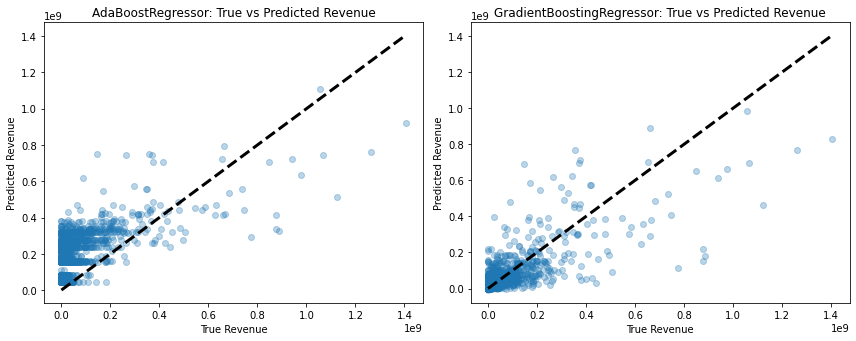

In [26]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(y_test, ada_y_pred, alpha=0.3)
ax1.set_xlabel('True Revenue')
ax1.set_ylabel('Predicted Revenue')
ax1.set_title('AdaBoostRegressor: True vs Predicted Revenue')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)

ax2.scatter(y_test, gb_y_pred, alpha=0.3)
ax2.set_xlabel('True Revenue')
ax2.set_ylabel('Predicted Revenue')
ax2.set_title('GradientBoostingRegressor: True vs Predicted Revenue')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)

plt.tight_layout()
plt.show()

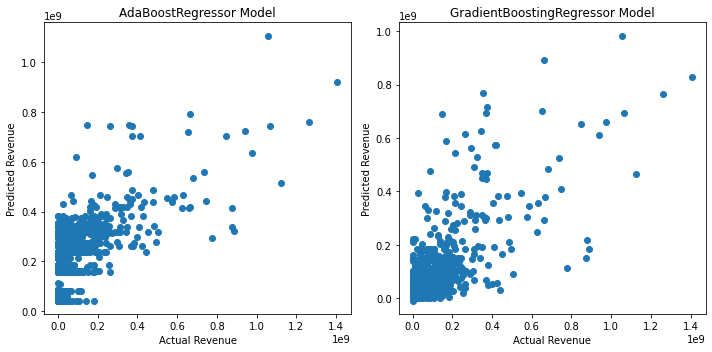

In [27]:
# Get predictions for both models
y_pred_ada = ada_model.predict(X_test)
y_pred_grad = gb_model.predict(X_test)

# Create scatter plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ada)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("AdaBoostRegressor Model")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_grad)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("GradientBoostingRegressor Model")

plt.tight_layout()
plt.show()